# Using Anything anime generator I want to fine tune it to colorize

Goal: 
1. Load the matching data pairs (Done)
2. Load colorization model
3. A function to remove color and replace with sketch pixel
4. Have the model guess the pixels missing pixels

Next step:
1. get model to generate color based on next time step

In [56]:
import os
import torch
from torch import nn
import torchvision
from torchvision import transforms, models as torchvision_models
from torch.utils.data import Dataset, DataLoader
import timm
import pandas as pd
from PIL import Image
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
from diffusers import StableDiffusionPipeline, AutoencoderKL, DiffusionPipeline
import clip

from torchvision.models import vgg16

In [69]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return 100
        # return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))

class Colorizer(LightningModule):
    def __init__(self, vae):
        super().__init__()
        self.model = vae
        vgg_model = vgg16(weights=True)

        self.loss_fn = VGGPerceptualLoss(vgg_model)
        # self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        sketch_imgs, color_imgs = batch
        num_batches = self.trainer.num_training_batches
        step = batch_idx % num_batches
        replaced_imgs = incremental_pixel_replacement_batch(color_imgs, sketch_imgs, step, num_batches)
        outputs = self(replaced_imgs).sample
        loss = self.loss_fn(outputs, color_imgs)
        scaled_loss = loss * color_imgs.size(0)

        
        self.log('train_loss', scaled_loss)
        return scaled_loss

    # def configure_optimizers(self):
    #     return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

def incremental_pixel_replacement_batch(color_images, sketch_images, step, total_steps):
    assert color_images.shape == sketch_images.shape, "Color and sketch images must have the same shape"

    # Calculate the replacement proportion
    alpha = step / total_steps

    # Generate random masks for the entire batch
    batch_size, channels, height, width = color_images.shape
    mask = torch.rand(batch_size, height, width, device=color_images.device) < alpha

    # Expand the mask to match the number of channels
    mask = mask.unsqueeze(1).expand(-1, channels, -1, -1)

    # Replace pixels in the color images with pixels from the sketch images using the mask
    replaced_images = torch.where(mask, sketch_images, color_images)
    
    return replaced_images

In [70]:
data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)


In [71]:
# pipeline = DiffusionPipeline.from_pretrained("AdamOswald1/Anything-Preservation")
# torch.save(pipeline.vae, 'anything-vae.pth')

In [72]:
vae = torch.load('anything-vae.pth', map_location='cpu')

In [73]:
# chkpt_file = 'checkpoints/v89-epoch-2.ckpt'
# model = Colorizer.load_from_checkpoint(chkpt_file, vae=vae, map_location='cpu')

In [74]:
model = Colorizer(vae)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=1)

logger = loggers.TensorBoardLogger("tb_logs")
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [76]:
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | AutoencoderKL     | 83.7 M
1 | loss_fn | VGGPerceptualLoss | 138 M 
----------------------------------------------
220 M     Trainable params
1.7 M     Non-trainable params
222 M     Total params
888.046   Total estimated model params size (MB)
/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 10:  59%|█████▉    | 59/100 [00:34<00:23,  1.72it/s, v_num=90]

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
model

Colorizer(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
          

In [77]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [78]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

Colorizer(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
          

In [94]:
idx = 100
# x, y = test_dataset[100]
x, y = training_dataset[idx]
output = model(x.unsqueeze(0)).sample

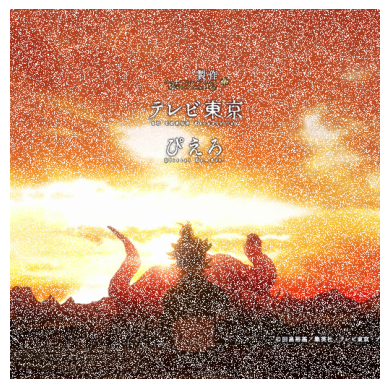

In [100]:
replaced_image = incremental_pixel_replacement(x, y, 8, 10)
viewTensor(replaced_image)

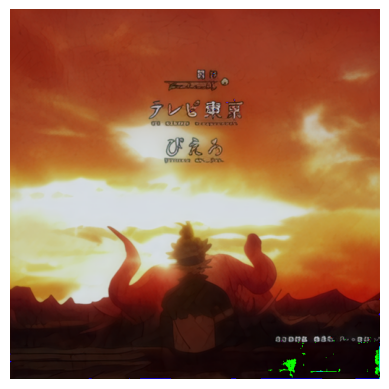

In [101]:
replaced_output = model(replaced_image.unsqueeze(0)).sample
viewTensor(replaced_output)

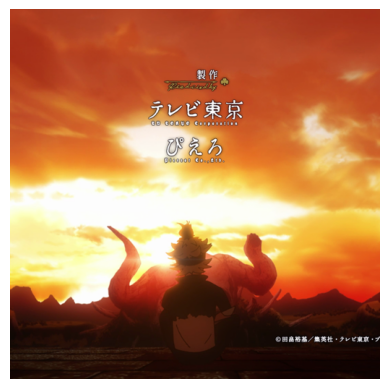

In [102]:
viewTensor(y)

In [25]:
step = 1
total_steps = 10
alpha = step/total_steps

In [26]:
color_image = y
sketch_image = x

In [27]:
def incremental_pixel_replacement(color_image, sketch_image, step, total_steps):
    alpha = step/total_steps
    mask = torch.rand_like(color_image[0]) < alpha
    mask = mask.unsqueeze(0).expand_as(color_image)

    replaced_image = torch.where(mask,sketch_image, color_image)
    return replaced_image

In [28]:
viewTensor(replaced_image)

NameError: name 'replaced_image' is not defined

In [104]:
def incremental_pixel_replacement_batch(color_images, sketch_images, step, total_steps):
    assert color_images.shape == sketch_images.shape, "Color and sketch images must have the same shape"

    # Calculate the replacement proportion
    alpha = step / total_steps

    # Generate random masks for the entire batch
    batch_size, channels, height, width = color_images.shape
    mask = torch.rand(batch_size, height, width, device=color_images.device) < alpha

    # Expand the mask to match the number of channels
    mask = mask.unsqueeze(1).expand(-1, channels, -1, -1)

    # Replace pixels in the color images with pixels from the sketch images using the mask
    replaced_images = torch.where(mask, sketch_images, color_images)
    
    return replaced_images

In [105]:
class Colorizer(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.sd_model = model
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        return self.sd_model(x)

    def training_step(self, batch, batch_idx):
        sketch_imgs, color_imgs = batch
        num_batches = self.trainer.num_training_batches
        step = batch_idx % num_batches
        incremental_pixel_replacement_batch(color_imgs, sketch_imgs, step, num_batches)
        outputs = self(replaced_imgs)
        loss = self.loss_fn(outputs, color_imgs)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-4)

In [103]:
model

Colorizer(
  (model): AutoencoderKL(
    (encoder): Encoder(
      (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down_blocks): ModuleList(
        (0): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0-1): 2 x ResnetBlock2D(
              (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
              (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (nonlinearity): SiLU()
            )
          )
          (downsamplers): ModuleList(
            (0): Downsample2D(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
            )
          )
        )
        (1): DownEncoderBlock2D(
          (resnets): ModuleList(
            (0): ResnetBlock2D(
          